# CS6120
# Lab 3 - PyTorch Intro & Recurrent Neural Networks
A subset of the MATH60629A tutorial at the University of Toronto by *Oleksiy Ostapenko*

(Author's original sources: [Deep Learning Book](https://www.deeplearningbook.org/), [Christophe Olah's Blog](http://colah.github.io/), RNNs [tutorial](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q) by Yen-Ling Kuo and Eugenio Piasini)

In this practical session, we will explore how to model sequential data using recurrent neural networks (RNNs). In the first part, we will build an intuition on some moving parts of RNNs on a toy problem. The second part of the tutorial will showcase an example of applying RNNs to a more realistic dataset of textual data.

Here we will use [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1) library, which is a popular open-source library that provides many convenient tools for building artificial neural networks.

# Part 1: simple example (learning a sine wave)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(235)
np.random.seed(235)

%matplotlib inline
import matplotlib.pyplot as plt

Let's first generating some data!

In [ ]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # targets are shifted by 1 step, since we're predicting the next step based on history

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

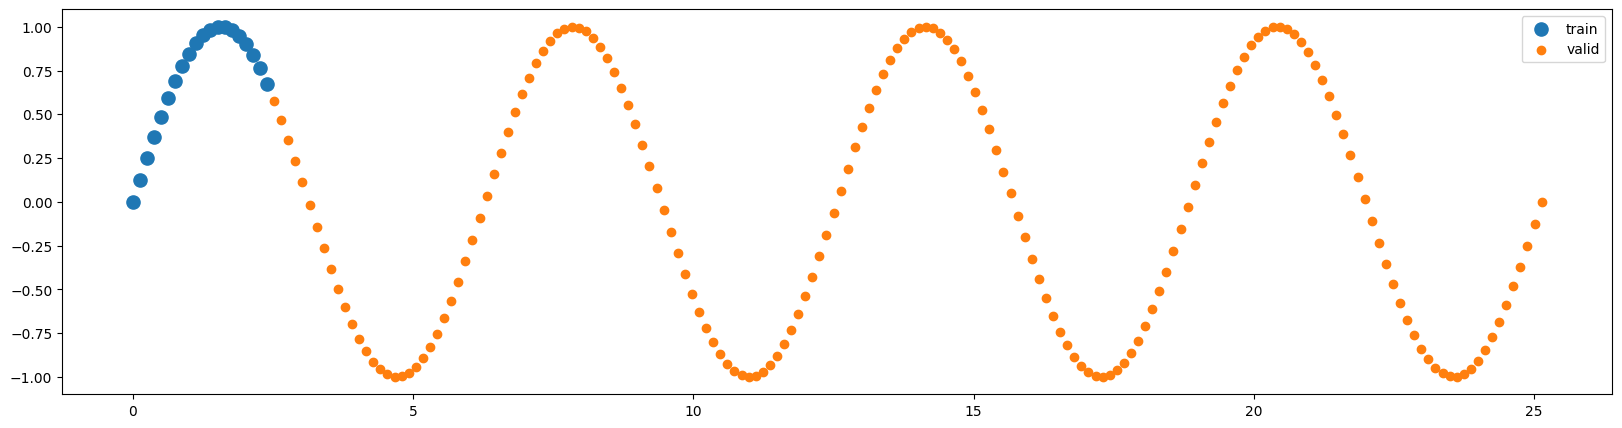

In [ ]:
seq_length = 200 #total sequence length
portion_train =0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

We formulate the task as predicting the point at time step $t+1$ given the sequence of previous inputs up until time step $t$. We, therefore, need to shift our targets by one as mentioned in the class. Let's have a closer look at our input and target data again **(note: targets are shifted by 1)**.

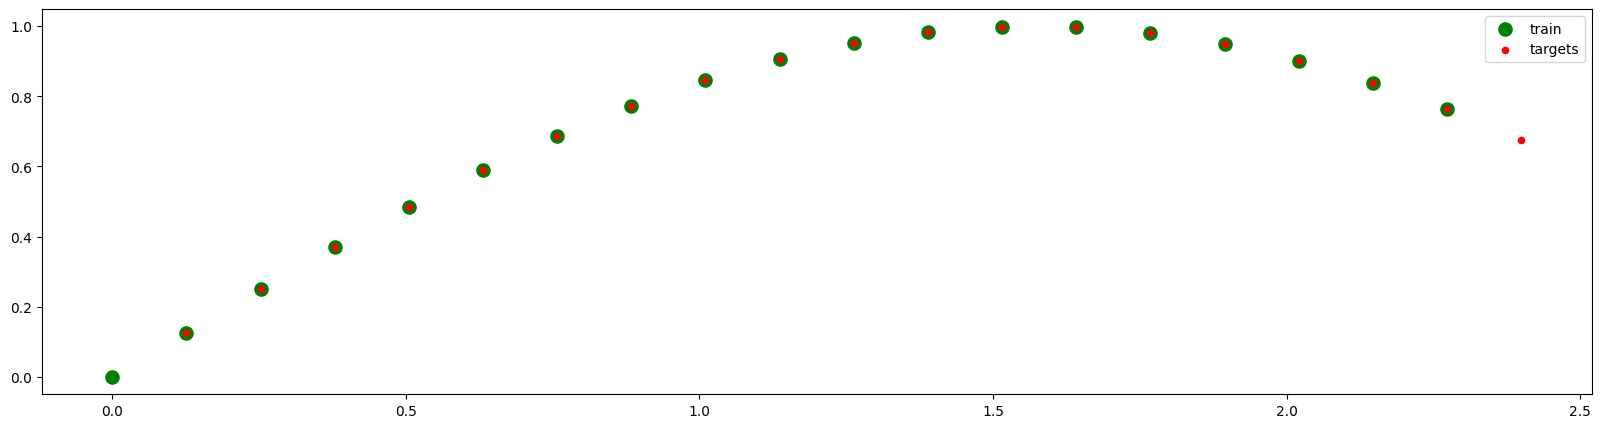

In [ ]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

We will use data generated from a sine curve for our toy sequential prediction problem. Namely, given some part of the sequence as training data (blue points in the visualization above), our model will be tasked to generate the rest of the sequence (orange points).

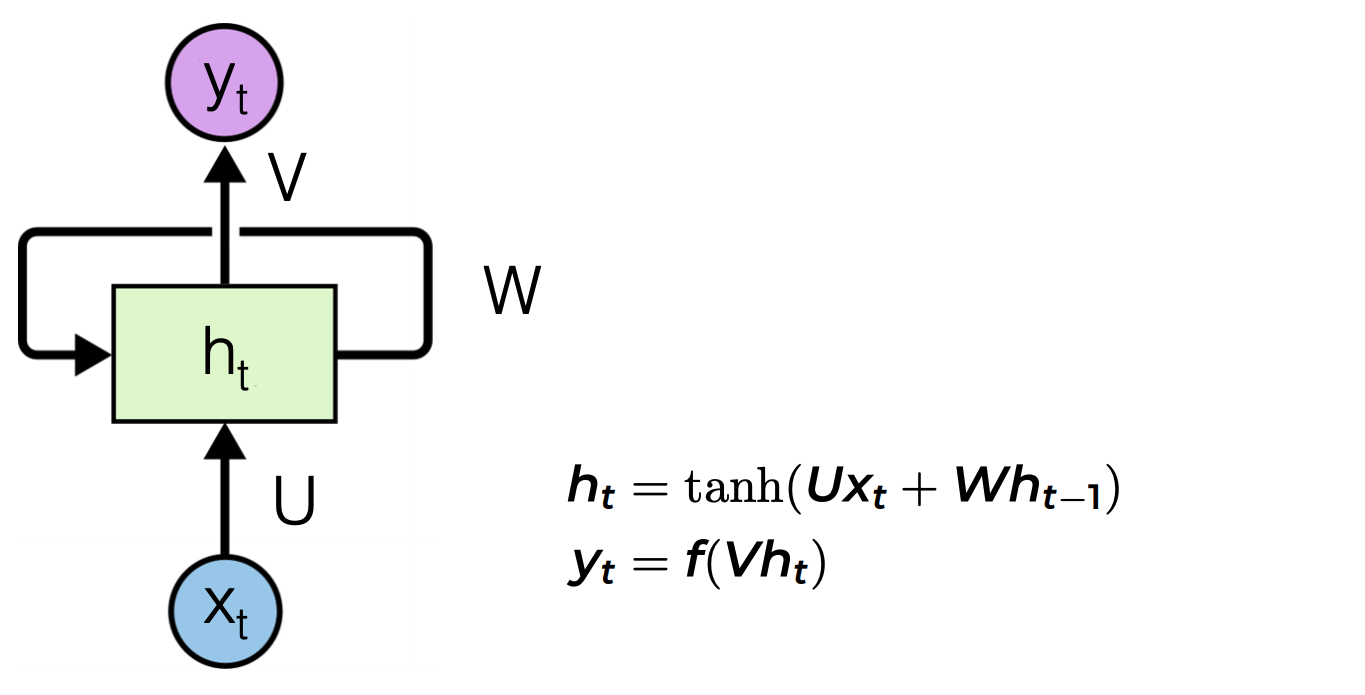
Image source http://colah.github.io/

As we have seen in the class, a simple recurrent network cell takes the current input at $X_t$ and produces an output ($y_t$) and a new hidden state that is passed through a recurrent connection to the next time step (in the figure above the recurrent connection uses weights W).

Let's first implement this simple RNN cell using Pytorch operations. Note, we use the $sigmoid$ activation (covered in the previous lab and lectures).

As you might recall from the previous lecture on feed-forward neural networks, the second equation in the figure above ($y_t = f(Vh_t)$) looks very similar to the feedforward layer. Indeed it is one, where $V$ denotes our learnable weights and $f$ is our activation function. Pytorch already provides us with an implementation of such a layer. We will add it outside of our simple RNN cell for convenience.


In [54]:
class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size)) # Weight for the input
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size)) # weight for hidden state

        self.b = torch.nn.Parameter(torch.randn(hidden_size)) # bias term

    def forward(self, x_t, state):

        h_prev = state
        matrx = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        h_t = torch.sigmoid(matrx)

        return h_t

Now, having implemented our simple recurrent cell, we need to put cells together to form a network.

Remember the principle of RNNs? The same(!) cell is used repeatedly receiving the new $X_t$ and the previous hidden state as input.

 We will also add our missing feed-forward layer (equation $y_t = f(Vh_t)$) here (we will set $f$ to identity, since we do not need any additional activation function here).

In [55]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        # The nn.Linear layer is added to transform the RNN's high-dimensional hidden state output to the desired output size.

    def init_hidden(self,):
        # we will initialize our hidden state with zeros
        return torch.zeros(1,self.hidden_size)

    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        for X_t in X:
            self.h = self.rnn_cell.forward(X_t, self.h)
            y_t = self.linear.forward(self.h)
            outputs.append(y_t)

        return torch.stack(outputs), self.h

**Question 1 (RNNs)** : in the standard feed-forward neural network, all the training and test samples are considered independently. Can you explain how this can be a bad fit for sequential data modeling like the stock market or sequential sine curve fitting?

**Question 2 (RNNs)**: given your answers to the previous question, can you explain in your own words, which role the hidden state ($h$) plays in RNNs?


**YOUR ANSWERS HERE**<br>
**Ans.1** Sequential data, like stock prices or sine waves, has inherent temporal dependencies. The value at a given time point is often closely related to its preceding values. feed-forward neural network lack mechanism to remember past inputs & hence cannot capture these dependencies, making them ill-suited for tasks where history significantly influences the future.

**Ans.2** In Recurrent Neural Networks (RNNs), the hidden state h serves as the network's memory. It plays a crucial role in capturing and retaining information from all previously seen inputs in a sequence, allowing the RNN to maintain a form of temporal continuity across the sequence.

Okay, we have implemented the 'forward path' of our RNN model. But what about the actual learning. The learning algorithm that is usually used to train RNNs is called [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time). Don't be afraid of the fancy name(!), the essential idea that underlines this and many other learning algorithms for the deep neural network is just repeatedly applying the chain rule of differentiation:

if $F = f(y), y = g(x)$, we have that $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (given f and g are differentiable functions).

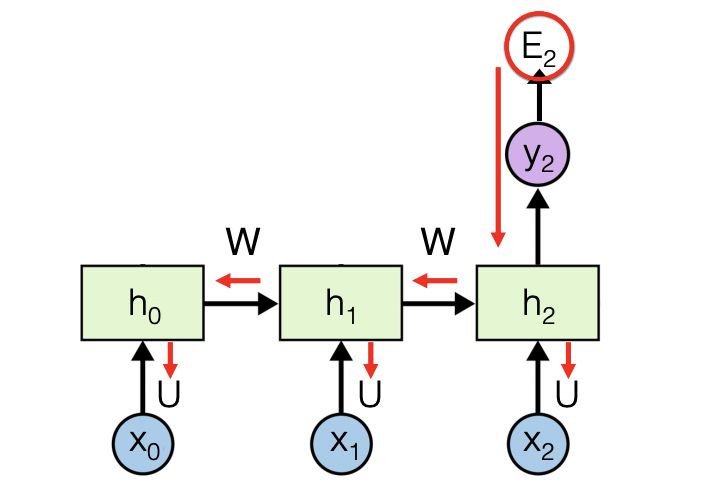
Image source http://colah.github.io/

The above image depicts a simple RNN with 3 states. Let's put it into mathematical equations ignoring the activation functions (and assuming our learnable weights are just scalars).

$h_o = U x_0$

$h_1 = U x_1 + W h_0$

$h_2 = U x_2 + W h_1$

Suppose we are dealing with a regression problem, let's include a simple L2 loss:

$E = \frac{1}{2} (h_2 - y)^2 $, where $y$ is the ground truth.

**Question 3 RNNs** : write down equations for the backpropagation through time for states $h_0$, $h_1$ and $h_2$ (hint: simply use the chain rule starting from the error term).

**YOUR ANSWER HERE**

Starting from the last state h2, we compute the gradient of the loss E with respect to h2​:
<br>
$dE / dh_2 = (h2 - y)$
<br>

using the chain rule, we can calculate the gradients with respect to h_1​ and h_0​. Since $h_2=UX_2+Wh_1$​, the gradient of h_2​ with respect to h_1​ is W, and using the chain rule we get:

$dE/dh_1 = dE/dh_2 * dh_2/dh_1 = (h_2 - y) * W$
<br>

Similarly, since $h_1​=Ux1​+Wh_0$​, the gradient of h_1​ with respect to h_0​ is also W, and we can calculate the gradient with respect to h_0​ as
<br>
$dE/dh_0 = dE/dh_1 * dh_1/dh_0 = (h_2 - y) * (W)^2$



Don't worry, we are not going to code the backpropagation equations by hand this time, Pytorch will do the tedious work of differentiation for us.

Finally, let's now train our simple RNN on the input sequence generated previously.

In [56]:
hidden_size = 20 # changing from 10 to 20 gives better predictions
learning_rate = 0.01
# feel free to experiment with these

In [ ]:
model = RNN(1,hidden_size) # first we instantiate our model

criterion = nn.MSELoss() # using mean squared loss
optimizer = optim.Adam(model.parameters(), learning_rate)

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()

    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.5760374069213867
Epoch 10: loss 0.06844554841518402
Epoch 20: loss 0.039089906960725784
Epoch 30: loss 0.02413555234670639
Epoch 40: loss 0.01565251685678959
Epoch 50: loss 0.011848369613289833
Epoch 60: loss 0.009136464446783066
Epoch 70: loss 0.006738568656146526
Epoch 80: loss 0.005173370707780123
Epoch 90: loss 0.004012662451714277
Epoch 100: loss 0.0029727600049227476
Epoch 110: loss 0.0020275076385587454
Epoch 120: loss 0.001284144469536841
Epoch 130: loss 0.0008714554714970291
Epoch 140: loss 0.0006681210361421108
Epoch 150: loss 0.0005257923039607704
Epoch 160: loss 0.0004271382640581578
Epoch 170: loss 0.0003575238224584609
Epoch 180: loss 0.0003035582776647061
Epoch 190: loss 0.0002617246937006712
Epoch 200: loss 0.00022853534028399736
Epoch 210: loss 0.00020187371410429478
Epoch 220: loss 0.000245535047724843
Epoch 230: loss 0.00016713941295165569
Epoch 240: loss 0.0001712862285785377
Epoch 250: loss 0.00014848180580884218
Epoch 260: loss 0.000132573317387141

Let's see how our trained model can predict the training labels. Given a point from our training data (time $t$), we will ask our model to generate the next point ($t+1$), one point at a time. We will carry over the hidden state along the sequence generation.

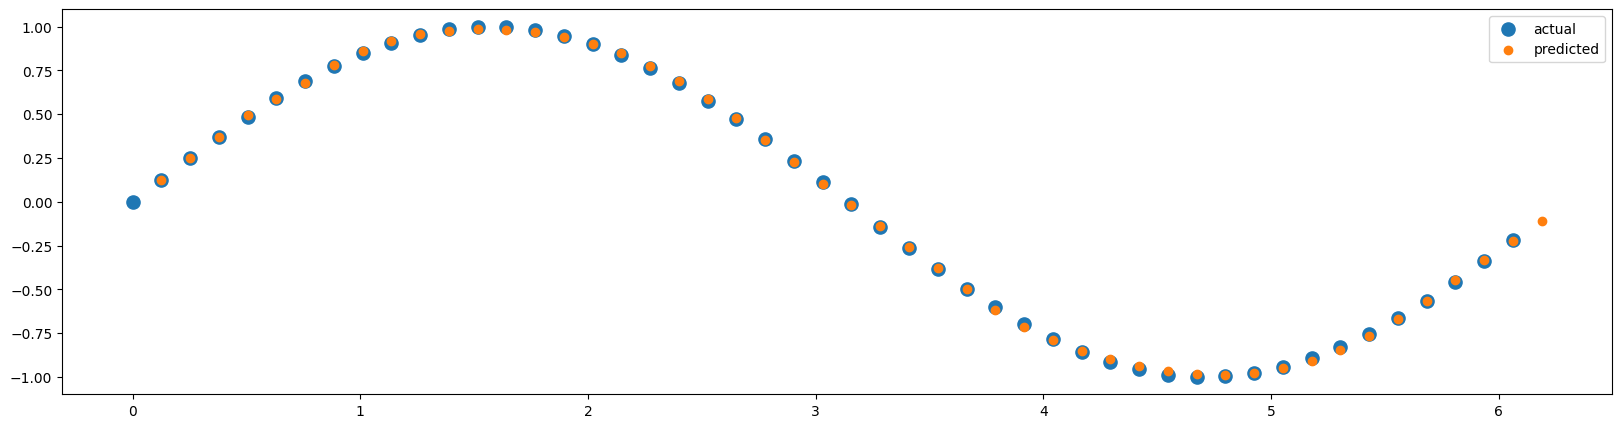

In [ ]:
def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    for i in range(train_x.shape[0]):
        input = train_x[i]
        input = input.view(1, 1, 1)

        # we will give the current (single) point and the (current)
        # hidden state as input to our model

        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev)
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

As we can see in the plot above, that our model has learned to fit the training part of the sequence almost perfectly.

But what about the unseen part of the sequence?

In [ ]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts


Let's generate the part of the sequence which was hidden from the model at training. Note, from the model's perspective, it is like generating completely new unseen data. If our data were e.g. text instead of a simple sine wave, we could ask our model to generate a completely new text, isn't that cool?

Note, to generate the unseen part of the sequence:
- we will first condition on the last point from the seen sequence, and ask the model to generate a new point
- then we will pass this newly generated point and the new hidden state as input to out model
- the model will then generate a new point conditioned on a point previously generated by the model
- In theory we could generate an infinitely long sequence on new data in this way.

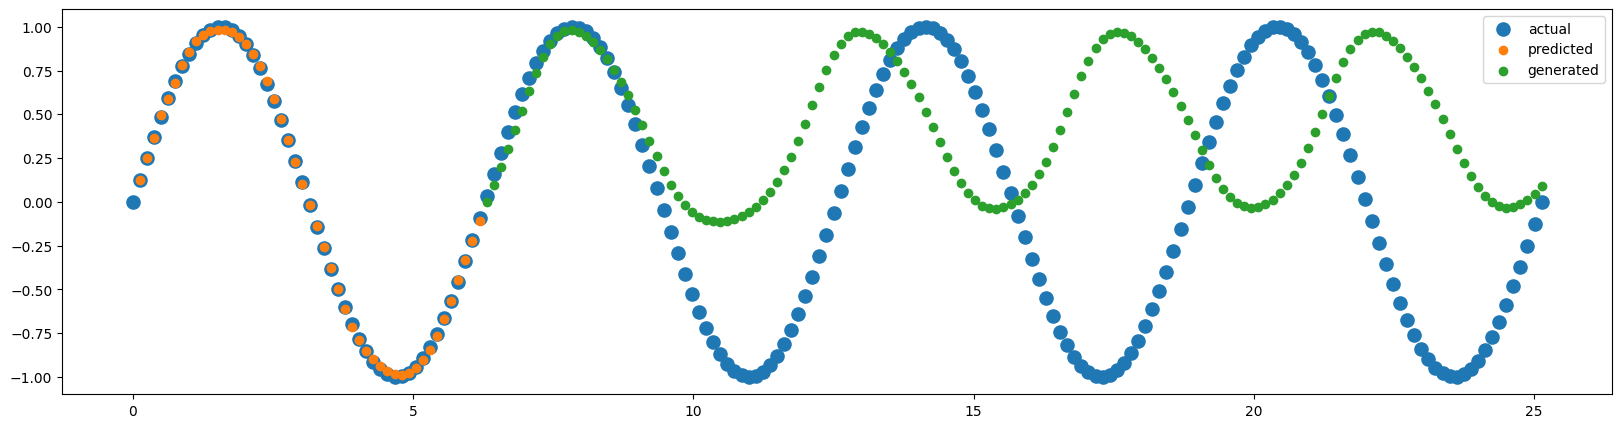

In [ ]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As can be seen in the plot above, our model's performance is quite poor when it comes to generating the unseen part of the sequence (shown in green).

Looking at our training sequence (the orange part in the plot above), does it actually contain the information needed to be able to capture the periodic nature of the sine wave? Well, even as a human, if you had never seen a sine wave before, you probably would not be able to learn what a sine wave is solely from observing half of the period length of a sine wave (you would probably think it's just a parabola).

**Question 4 (RNNs)**: try increasing the training sequence length ($portion\_train$) in the code snippet below. (Hint: set the training length such that it includes at least one complete cycle of the sine wave.)

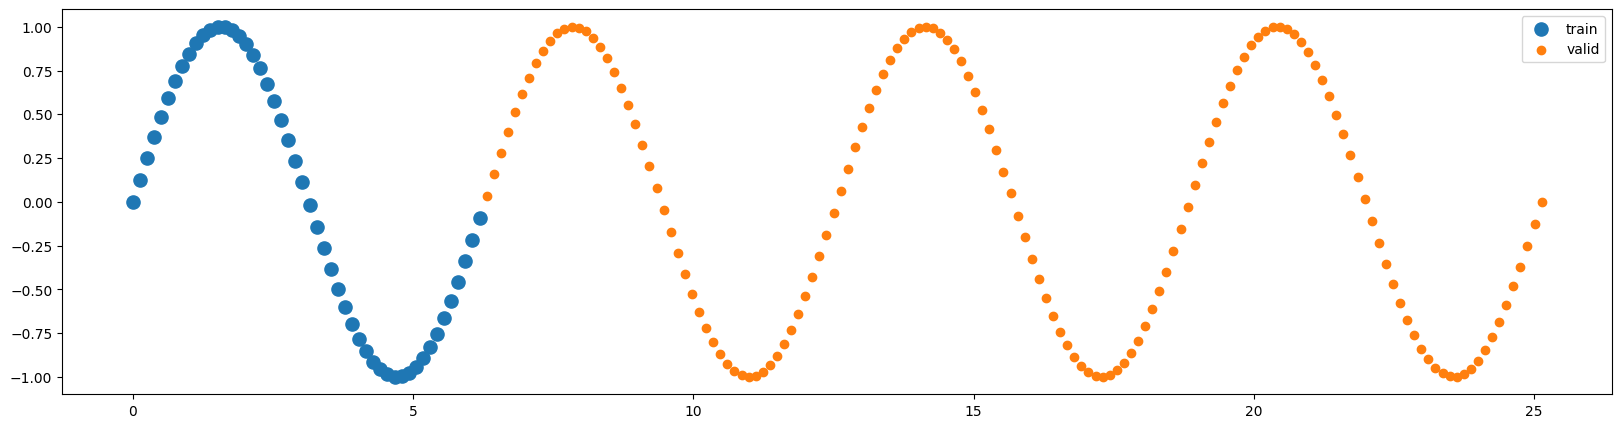

In [ ]:

portion_train = 0.25 # change this parameter to try out a longer training sequence to cover at least one period

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

Let's train our model again, for a bit longer this time and see the result.

In [ ]:
model = RNN(1,hidden_size)
optimizer = optim.Adam(model.parameters(), learning_rate)
epochs = 500 #
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

Epoch 0: loss 0.3703482747077942
Epoch 10: loss 0.18866367638111115
Epoch 20: loss 0.060438621789216995
Epoch 30: loss 0.018309710547327995
Epoch 40: loss 0.01878034509718418
Epoch 50: loss 0.013463994488120079
Epoch 60: loss 0.011166533455252647
Epoch 70: loss 0.010268907062709332
Epoch 80: loss 0.009250731207430363
Epoch 90: loss 0.00851302407681942
Epoch 100: loss 0.007901526987552643
Epoch 110: loss 0.0073552206158638
Epoch 120: loss 0.006867352873086929
Epoch 130: loss 0.006421657279133797
Epoch 140: loss 0.006002041976898909
Epoch 150: loss 0.00559471920132637
Epoch 160: loss 0.005187102593481541
Epoch 170: loss 0.004763557109981775
Epoch 180: loss 0.004298888146877289
Epoch 190: loss 0.0037235140334814787
Epoch 200: loss 0.0027182388585060835
Epoch 210: loss 0.0015331298345699906
Epoch 220: loss 0.0010672968346625566
Epoch 230: loss 0.0007572409813292325
Epoch 240: loss 0.0005224786000326276
Epoch 250: loss 0.00037545079248957336
Epoch 260: loss 0.0002889692550525069
Epoch 270: 

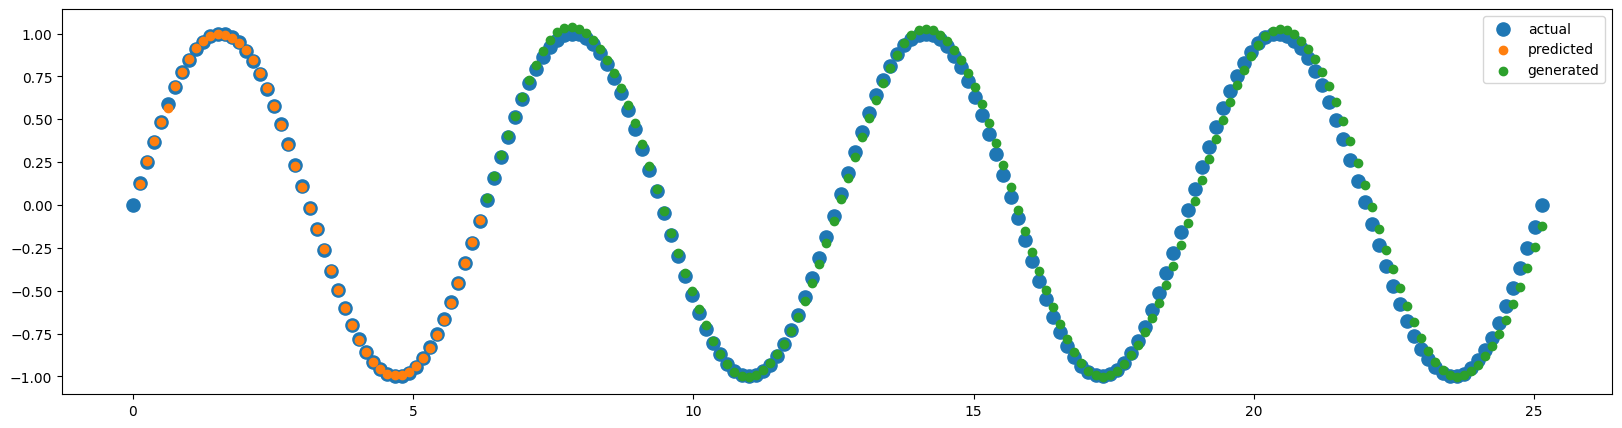

In [ ]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len,
                                            starting_point=predictions_train[-1],
                                            hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

And voilà, our new model is somewhat better in capturing the periodic nature of the sine wave.

Note, if you rerun the training procedure for several times you will observe that each time you get a different result. This is due to the random reinitialization of the trainable weight in our RNN cell each time you restart training (re-instantiate the network object):

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


We certainly could try to get some better results by either:
- further hyperparameter tuning
- further increasing the length of the training sequence (MORE DATA is always good)

These are valid strategies often used in deep learning to improve the performance of the models. Yet, many times the real innovations come from improving the actual learning algorithms.